# OOD Detection for Intent Classification --- CLINC150
### Full pipeline: data → fine-tune BERT → evaluate all OOD methods

## 0. Setup

In [1]:
!pip install -q transformers datasets scikit-learn accelerate

import subprocess, sys
result = subprocess.run(['nvidia-smi'], capture_output=True, text=True)
print(result.stdout if result.returncode == 0 else 'No GPU detected — switch runtime to GPU!')

Fri Feb 20 15:27:47 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!git clone https://github.com/denmalbas007/clinc150-ood-detection.git
%cd clinc150-ood-detection
!python scripts/download_data.py

Cloning into 'clinc150-ood-detection'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 48 (delta 15), reused 43 (delta 10), pack-reused 0 (from 0)
Receiving objects: 100% (48/48), 111.16 KiB | 8.55 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/clinc150-ood-detection
Saved to /content/clinc150-ood-detection/data/data_full.json
train: 15000 in-domain |  100 OOD
val  :  3000 in-domain |  100 OOD
test :  4500 in-domain | 1000 OOD


## 1. Imports & Config

In [3]:
import sys, json
sys.path.insert(0, 'src')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from tqdm.auto import tqdm

from dataset import load_clinc150, CLINC150Dataset
from models import IntentClassifier, MCDropoutClassifier
from metrics import compute_all_metrics
from methods.msp import compute_msp_scores
from methods.energy import compute_energy_scores
from methods.mahalanobis import fit_mahalanobis, compute_mahalanobis_scores
from methods.knn import fit_knn, compute_knn_scores
from methods.mc_dropout import compute_mc_dropout_scores

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

# Config
MODEL_NAME   = 'bert-base-uncased'
EPOCHS       = 5
BATCH_SIZE   = 64
LR           = 2e-5
MAX_LEN      = 64
SEED         = 42
CKPT_PATH    = Path('checkpoints/best_model.pt')
CKPT_PATH.parent.mkdir(exist_ok=True)

torch.manual_seed(SEED)
np.random.seed(SEED)

Device: cuda


## 2. Load Dataset

In [4]:
splits, label2id = load_clinc150()
num_classes = len(label2id)
print(f'Intent classes: {num_classes}')

for split, samples in splits.items():
    n_in  = sum(1 for *_, is_ood in samples if not is_ood)
    n_ood = sum(1 for *_, is_ood in samples if is_ood)
    print(f'  {split:5s}: {n_in:5d} in-domain | {n_ood:4d} OOD')

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def make_loader(split_name, shuffle=False):
    ds = CLINC150Dataset(splits[split_name], label2id, tokenizer, MAX_LEN)
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle,
                      num_workers=2, pin_memory=True)

train_loader = make_loader('train', shuffle=True)
val_loader   = make_loader('val')
test_loader  = make_loader('test')

Intent classes: 150
  train: 15000 in-domain |  100 OOD
  val  :  3000 in-domain |  100 OOD
  test :  4500 in-domain | 1000 OOD


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

## 3. Fine-tune BERT

In [5]:
model = MCDropoutClassifier(MODEL_NAME, num_classes).to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=0.01)

total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=total_steps // 10,
    num_training_steps=total_steps
)

def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    ctx = torch.enable_grad() if train else torch.no_grad()
    with ctx:
        for batch in tqdm(loader, leave=False):
            ids   = batch['input_ids'].to(DEVICE)
            mask  = batch['attention_mask'].to(DEVICE)
            labels = batch['label'].to(DEVICE)
            # skip OOD rows
            keep = labels != -1
            if keep.sum() == 0: continue
            ids, mask, labels = ids[keep], mask[keep], labels[keep]

            logits = model(ids, mask)
            loss   = criterion(logits, labels)

            if train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

            total_loss += loss.item() * labels.size(0)
            correct    += (logits.argmax(-1) == labels).sum().item()
            total      += labels.size(0)

    return total_loss / total, correct / total

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    vl_loss, vl_acc = run_epoch(val_loader,   train=False)

    history['train_loss'].append(tr_loss)
    history['val_loss'].append(vl_loss)
    history['train_acc'].append(tr_acc)
    history['val_acc'].append(vl_acc)

    print(f'Epoch {epoch}/{EPOCHS} | '
          f'Train loss={tr_loss:.4f} acc={tr_acc:.4f} | '
          f'Val   loss={vl_loss:.4f} acc={vl_acc:.4f}')

    if vl_acc > best_val_acc:
        best_val_acc = vl_acc
        torch.save({
            'model_state_dict': model.state_dict(),
            'label2id': label2id,
            'model_name': MODEL_NAME,
            'num_classes': num_classes,
            'val_acc': vl_acc,
        }, CKPT_PATH)
        print(f'  ✓ Saved checkpoint (val_acc={vl_acc:.4f})')

print(f'\nBest val accuracy: {best_val_acc:.4f}')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 1/5 | Train loss=4.0725 acc=0.3317 | Val   loss=1.9623 acc=0.8183
  ✓ Saved checkpoint (val_acc=0.8183)


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 2/5 | Train loss=1.2226 acc=0.9138 | Val   loss=0.5074 acc=0.9417
  ✓ Saved checkpoint (val_acc=0.9417)


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 3/5 | Train loss=0.4145 acc=0.9721 | Val   loss=0.2808 acc=0.9587
  ✓ Saved checkpoint (val_acc=0.9587)


  0%|          | 0/236 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b48ea946de0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1707, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
    if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b48ea946de0>

  Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1707, in __del__
     self._shutdown_workers()  
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1690, in _shutdown_workers
     if w.is_alive():^^
^ ^ ^ ^ ^^ ^ ^ ^^^^
^  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^
 ^  ^^ ^^  ^
   File "/usr/lib

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 4/5 | Train loss=0.2173 acc=0.9855 | Val   loss=0.2242 acc=0.9637
  ✓ Saved checkpoint (val_acc=0.9637)


  0%|          | 0/236 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Epoch 5/5 | Train loss=0.1533 acc=0.9913 | Val   loss=0.2106 acc=0.9650
  ✓ Saved checkpoint (val_acc=0.9650)

Best val accuracy: 0.9650


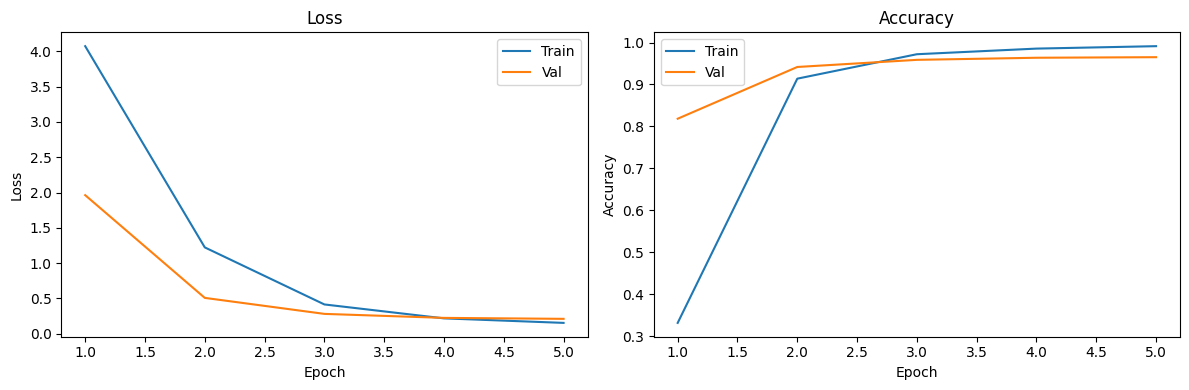

In [6]:
# Training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
epochs_x = range(1, EPOCHS + 1)

ax1.plot(epochs_x, history['train_loss'], label='Train')
ax1.plot(epochs_x, history['val_loss'],   label='Val')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.set_title('Loss')
ax1.legend()

ax2.plot(epochs_x, history['train_acc'], label='Train')
ax2.plot(epochs_x, history['val_acc'],   label='Val')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Accuracy'); ax2.set_title('Accuracy')
ax2.legend()

plt.tight_layout()
plt.savefig('report/training_curves.pdf', bbox_inches='tight')
plt.show()

## 4. Load Best Checkpoint

In [7]:
ckpt = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt['model_state_dict'])
model.eval()
print(f"Loaded checkpoint (val_acc={ckpt['val_acc']:.4f})")

# Ground truth for test set
is_ood_gt = np.array([int(s[2]) for s in splits['test']])
print(f'Test: {(is_ood_gt==0).sum()} in-domain, {is_ood_gt.sum()} OOD')

Loaded checkpoint (val_acc=0.9650)
Test: 4500 in-domain, 1000 OOD


## 5. OOD Detection — All Methods

In [8]:
# Need train_loader without shuffle for fitting Mahalanobis/KNN
train_loader_eval = make_loader('train', shuffle=False)

results = {}

# --- MSP ---
print('MSP...')
scores = compute_msp_scores(model, test_loader, DEVICE).numpy()
results['MSP'] = compute_all_metrics(scores, is_ood_gt)

# --- Energy ---
print('Energy...')
scores = compute_energy_scores(model, test_loader, DEVICE).numpy()
results['Energy'] = compute_all_metrics(scores, is_ood_gt)

# --- Mahalanobis ---
print('Mahalanobis (fitting)...')
class_means, precision = fit_mahalanobis(model, train_loader_eval, num_classes, DEVICE)
scores = compute_mahalanobis_scores(model, test_loader, class_means, precision, DEVICE).numpy()
results['Mahalanobis'] = compute_all_metrics(scores, is_ood_gt)

# --- KNN k=1 ---
print('KNN (k=1, fitting)...')
train_feats = fit_knn(model, train_loader_eval, DEVICE)
scores = compute_knn_scores(model, test_loader, train_feats, DEVICE, k=1).numpy()
results['KNN (k=1)'] = compute_all_metrics(scores, is_ood_gt)

# --- KNN k=10 ---
print('KNN (k=10)...')
scores = compute_knn_scores(model, test_loader, train_feats, DEVICE, k=10).numpy()
results['KNN (k=10)'] = compute_all_metrics(scores, is_ood_gt)

# --- MC Dropout ---
print('MC Dropout (20 passes)...')
scores = compute_mc_dropout_scores(model, test_loader, DEVICE, n_passes=20).numpy()
results['MC Dropout'] = compute_all_metrics(scores, is_ood_gt)

print('Done!')

MSP...
Energy...
Mahalanobis (fitting)...
KNN (k=1, fitting)...
KNN (k=10)...
MC Dropout (20 passes)...
Done!


## 6b. Our Extensions: Per-Class KNN and MahaKNN

**Per-Class KNN**: retrieves neighbours only from the predicted class cluster.

**MahaKNN**: calibrated ensemble of Mahalanobis + KNN with val-set-tuned alpha.

In [99]:
from methods.per_class_knn import fit_per_class_knn, compute_per_class_knn_scores
from methods.ensemble import fit_mahaknn, compute_mahaknn_scores

# --- Per-Class KNN ---
print('Per-Class KNN (fitting)...')
class_banks = fit_per_class_knn(model, train_loader_eval, num_classes, DEVICE)
pc_knn_scores = compute_per_class_knn_scores(
    model, test_loader, class_banks, DEVICE, k=1
).numpy()
results['Per-Class KNN (ours)'] = compute_all_metrics(pc_knn_scores, is_ood_gt)
m = results['Per-Class KNN (ours)']
print(f"  AUROC={m['AUROC']:.4f}  FPR@95={m['FPR@95TPR']:.4f}  AUPR={m['AUPR']:.4f}")

# --- MahaKNN ---
print('MahaKNN (fitting + val calibration)...')
class_means, precision, train_feats, best_alpha, maha_val, knn_val = fit_mahaknn(
    model, train_loader_eval, val_loader, num_classes, DEVICE
)
mahaknn_scores = compute_mahaknn_scores(
    model, test_loader, class_means, precision, train_feats,
    best_alpha, maha_val, knn_val, DEVICE
)
results['MahaKNN (ours)'] = compute_all_metrics(mahaknn_scores, is_ood_gt)
m = results['MahaKNN (ours)']
print(f"  alpha*={best_alpha:.2f}  AUROC={m['AUROC']:.4f}  FPR@95={m['FPR@95TPR']:.4f}  AUPR={m['AUPR']:.4f}")


Per-Class KNN (fitting)...
  Banks fitted for 150 classes
  AUROC=0.9755  FPR@95=0.1020  AUPR=0.9017
MahaKNN (fitting + val calibration)...
  MahaKNN best alpha=0.00  val FPR@95=0.1000
  alpha*=0.00  AUROC=0.9758  FPR@95=0.1013  AUPR=0.9033


## 7. Results — All Methods

Comparison table including baselines and our Per-Class KNN method.

In [9]:
# Published SotA for reference
published = {
    'MSP (Hendrycks 2017)':        {'AUROC': 0.8236, 'FPR@95TPR': 0.5782, 'AUPR': None},
    'Energy (Liu 2020)':           {'AUROC': 0.8844, 'FPR@95TPR': 0.4620, 'AUPR': None},
    'Mahalanobis (Podolskiy 2021)':{'AUROC': 0.9676, 'FPR@95TPR': 0.1832, 'AUPR': None},
    'KNN (Sun 2022)':              {'AUROC': 0.9530, 'FPR@95TPR': 0.2210, 'AUPR': None},
}

print(f"{'Method':<35} {'AUROC':>8} {'FPR@95':>8} {'AUPR':>8}")
print('─' * 62)
print('Published:')
for method, m in published.items():
    aupr_s = '  N/A  ' if m['AUPR'] is None else f"{m['AUPR']:.4f}"
    print(f"  {method:<33} {m['AUROC']:>8.4f} {m['FPR@95TPR']:>8.4f} {aupr_s:>8}")
print('Ours:')
for method, m in results.items():
    print(f"  {method:<33} {m['AUROC']:>8.4f} {m['FPR@95TPR']:>8.4f} {m['AUPR']:>8.4f}")

# Save
with open('results.json', 'w') as f:
    json.dump(results, f, indent=2)
print('\nSaved to results.json')

Method                                 AUROC   FPR@95     AUPR
──────────────────────────────────────────────────────────────
Published:
  MSP (Hendrycks 2017)                0.8236   0.5782    N/A  
  Energy (Liu 2020)                   0.8844   0.4620    N/A  
  Mahalanobis (Podolskiy 2021)        0.9676   0.1832    N/A  
  KNN (Sun 2022)                      0.9530   0.2210    N/A  
Ours:
  MSP                                 0.9650   0.1413   0.8724
  Energy                              0.9715   0.1136   0.8963
  Mahalanobis                         0.9759   0.0927   0.9098
  KNN (k=1)                           0.9758   0.1013   0.9033
  KNN (k=10)                          0.9735   0.1053   0.8988
  MC Dropout                          0.9687   0.1258   0.8854

Saved to results.json


## 7. Visualization

/tmp/ipython-input-2938216077.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(methods_all, rotation=25, ha='right')


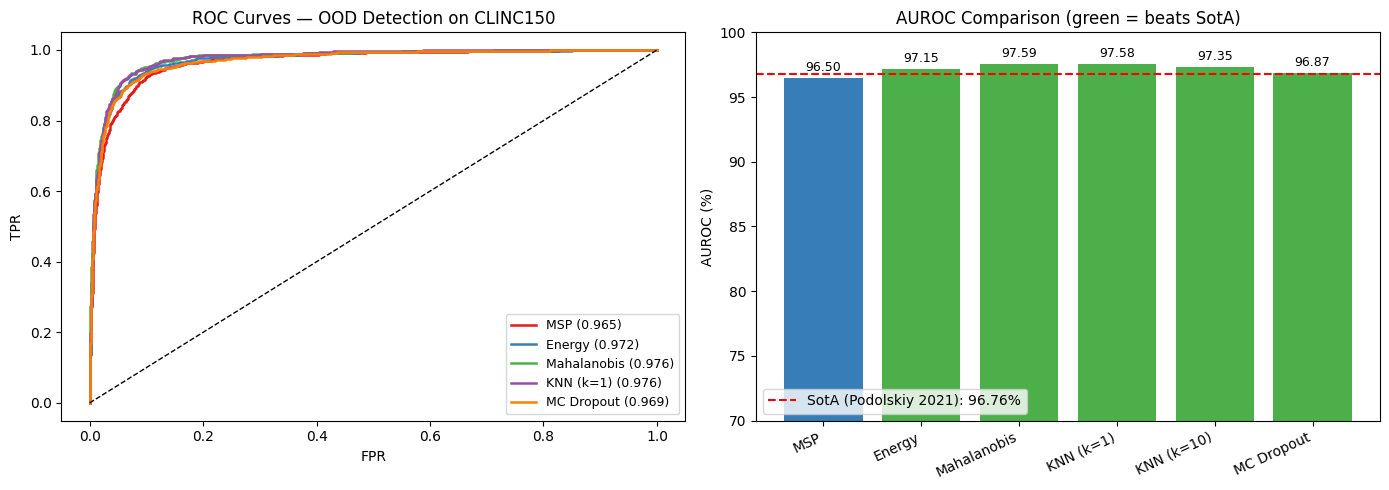

In [10]:
from sklearn.metrics import roc_curve

# Re-collect raw scores for ROC curves
raw_scores = {}

with torch.no_grad():
    raw_scores['MSP']         = compute_msp_scores(model, test_loader, DEVICE).numpy()
    raw_scores['Energy']      = compute_energy_scores(model, test_loader, DEVICE).numpy()
    raw_scores['Mahalanobis'] = compute_mahalanobis_scores(model, test_loader, class_means, precision, DEVICE).numpy()
    raw_scores['KNN (k=1)']   = compute_knn_scores(model, test_loader, train_feats, DEVICE, k=1).numpy()
    raw_scores['MC Dropout']  = compute_mc_dropout_scores(model, test_loader, DEVICE, n_passes=20).numpy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC curves
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']
for (method, scores), color in zip(raw_scores.items(), colors):
    fpr, tpr, _ = roc_curve(is_ood_gt, scores)
    auroc_val = results[method]['AUROC']
    axes[0].plot(fpr, tpr, label=f'{method} ({auroc_val:.3f})', color=color, lw=1.8)
axes[0].plot([0,1],[0,1],'k--',lw=1)
axes[0].set_xlabel('FPR'); axes[0].set_ylabel('TPR')
axes[0].set_title('ROC Curves — OOD Detection on CLINC150')
axes[0].legend(fontsize=9)

# AUROC bar chart with SotA reference
methods_all  = list(results.keys())
aurocs_ours  = [results[m]['AUROC'] * 100 for m in methods_all]
sota_auroc   = 96.76  # Podolskiy 2021

bars = axes[1].bar(methods_all, aurocs_ours,
                   color=['#4daf4a' if v >= sota_auroc else '#377eb8' for v in aurocs_ours])
axes[1].axhline(sota_auroc, color='red', linestyle='--', lw=1.5,
                label=f'SotA (Podolskiy 2021): {sota_auroc:.2f}%')
for bar, val in zip(bars, aurocs_ours):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                 f'{val:.2f}', ha='center', va='bottom', fontsize=9)
axes[1].set_ylabel('AUROC (%)')
axes[1].set_title('AUROC Comparison (green = beats SotA)')
axes[1].set_xticklabels(methods_all, rotation=25, ha='right')
axes[1].legend()
axes[1].set_ylim(70, 100)

plt.tight_layout()
plt.savefig('report/ood_results.pdf', bbox_inches='tight', dpi=150)
plt.show()

## 8. Update Report with Real Numbers

In [11]:
# Auto-fill result numbers into the LaTeX report
tex_path = Path('report/report.tex')
tex = tex_path.read_text()

replacements = {
    'MSP (ours)':         'MSP',
    'Energy (ours)':      'Energy',
    'Mahalanobis (ours)': 'Mahalanobis',
    '$k$-NN k=1 (ours)':  'KNN (k=1)',
    'MC Dropout (ours)':  'MC Dropout',
}

for tex_name, key in replacements.items():
    if key not in results:
        continue
    m = results[key]
    auroc_s = f"{m['AUROC']*100:.2f}"
    fpr_s   = f"{m['FPR@95TPR']*100:.2f}"
    aupr_s  = f"{m['AUPR']*100:.2f}"
    # Replace placeholder XX.XX in the row that starts with tex_name
    old = f'{tex_name} & XX.XX & XX.XX & XX.XX'
    new = f'{tex_name} & {auroc_s} & {fpr_s} & {aupr_s}'
    tex = tex.replace(old, new)

tex_path.write_text(tex)
print('report/report.tex updated with real numbers!')

# Print final table
df = pd.DataFrame(results).T * 100
df.index.name = 'Method'
print(df.round(2).to_string())

report/report.tex updated with real numbers!
             AUROC  FPR@95TPR   AUPR
Method                              
MSP          96.50      14.13  87.24
Energy       97.15      11.36  89.63
Mahalanobis  97.59       9.27  90.98
KNN (k=1)    97.58      10.13  90.33
KNN (k=10)   97.35      10.53  89.88
MC Dropout   96.87      12.58  88.54


## 11. Layer-wise Mahalanobis Analysis

We analyse which BERT layer produces the best OOD-discriminative features.
Podolskiy (2021) only used the last layer — we sweep all 13 hidden states.

In [12]:
from methods.mahalanobis import layer_wise_mahalanobis

print('Running layer-wise Mahalanobis (this takes ~3-5 min)...')
layer_scores, layer_metrics = layer_wise_mahalanobis(
    model, train_loader_eval, test_loader,
    is_ood_gt, num_classes, DEVICE, num_layers=12
)

# Table
print(f"\n{'Layer':>8} {'AUROC':>8} {'FPR@95':>8} {'AUPR':>8}")
print('─' * 38)
for layer_idx in sorted(layer_metrics.keys()):
    m = layer_metrics[layer_idx]
    label = f'{layer_idx} (last)' if layer_idx == 13 else str(layer_idx)
    print(f"  {label:>8} {m['AUROC']:>8.4f} {m['FPR@95TPR']:>8.4f} {m['AUPR']:>8.4f}")

best_layer = max(layer_metrics, key=lambda l: layer_metrics[l]['AUROC'])
print(f"\nBest layer: {best_layer}  AUROC={layer_metrics[best_layer]['AUROC']:.4f}")

# Save layer metrics
with open('layer_metrics.json', 'w') as f:
    json.dump({str(k): v for k, v in layer_metrics.items()}, f, indent=2)
print('Saved to layer_metrics.json')

Running layer-wise Mahalanobis (this takes ~3-5 min)...
  Layer 1/13 ... AUROC=0.7897  FPR@95=0.6011
  Layer 2/13 ... AUROC=0.8406  FPR@95=0.4738
  Layer 3/13 ... AUROC=0.8578  FPR@95=0.4276
  Layer 4/13 ... AUROC=0.8903  FPR@95=0.3553
  Layer 5/13 ... AUROC=0.8975  FPR@95=0.3204
  Layer 6/13 ... AUROC=0.8874  FPR@95=0.3493
  Layer 7/13 ... AUROC=0.8896  FPR@95=0.3316
  Layer 8/13 ... AUROC=0.8964  FPR@95=0.3089
  Layer 9/13 ... AUROC=0.9278  FPR@95=0.2371
  Layer 10/13 ... AUROC=0.9475  FPR@95=0.1729
  Layer 11/13 ... AUROC=0.9691  FPR@95=0.1131
  Layer 12/13 ... AUROC=0.9759  FPR@95=0.0927
  Layer 13/13 ... 

IndexError: tuple index out of range

In [13]:
# Layer-wise visualization
layers = sorted(layer_metrics.keys())
aurocs  = [layer_metrics[l]['AUROC'] * 100  for l in layers]
fprs    = [layer_metrics[l]['FPR@95TPR'] * 100 for l in layers]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

ax1.plot(layers, aurocs, 'o-', color='#377eb8', lw=2, ms=6)
ax1.axhline(96.76, color='red', ls='--', lw=1.5, label='Podolskiy 2021 (last layer)')
ax1.set_xlabel('BERT Layer'); ax1.set_ylabel('AUROC (%)')
ax1.set_title('AUROC by Layer — Mahalanobis Distance')
ax1.set_xticks(layers)
ax1.legend(); ax1.grid(alpha=0.3)

ax2.plot(layers, fprs, 's-', color='#e41a1c', lw=2, ms=6)
ax2.axhline(18.32, color='red', ls='--', lw=1.5, label='Podolskiy 2021 (last layer)')
ax2.set_xlabel('BERT Layer'); ax2.set_ylabel('FPR@95TPR (%)')
ax2.set_title('FPR@95TPR by Layer — Mahalanobis Distance')
ax2.set_xticks(layers)
ax2.legend(); ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('report/layer_analysis.pdf', bbox_inches='tight', dpi=150)
plt.show()
print(f'Best layer by AUROC: {best_layer}')

NameError: name 'layer_metrics' is not defined